# 🎶 음악 생성 - MuseGAN

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/11_music/02_musegan/musegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 musegan_utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
    # output 디렉토리를 만듭니다.
    !mkdir parsed_data
    !mkdir output
    !mkdir bach-chorales
    # 악보 이미지 생성을 위해
    !apt-get install lilypond > /dev/null

--2024-04-08 04:51:27--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/11_music/02_musegan/musegan_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1833 (1.8K) [text/plain]
Saving to: ‘musegan_utils.py’

musegan_utils.py    100%[===================>]   1.79K  --.-KB/s    in 0s      

2024-04-08 04:51:28 (36.9 MB/s) - ‘musegan_utils.py’ saved [1833/1833]

Extracting templates from packages: 100%


이 노트북에서는 바흐 코랄 스타일의 음악을 생성하는 MuseGAN 모델을 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)

from musegan_utils import notes_to_midi, draw_score

## 0. 파라미터 <a name="parameters"></a>

In [3]:
BATCH_SIZE = 64

N_BARS = 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 1000
LOAD_MODEL = False

## 1. 데이터 준비

In [4]:
if 'google.colab' in sys.modules:
    !curl -LO https://github.com/czhuang/JSB-Chorales-dataset/raw/master/Jsb16thSeparated.npz -s
    !mv Jsb16thSeparated.npz bach-chorales

In [5]:
# 데이터 로드
file = os.path.join("./bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [6]:
N_SONGS = len(data)
print(f"데이터셋에 있는 코랄 개수: {N_SONGS}")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"코랄 0번의 크기: {N_BEATS, N_TRACKS}")
print("\n코랄 0")
print(chorale[:8])

데이터셋에 있는 코랄 개수: 229
코랄 0번의 크기: (192, 4)

코랄 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]


In [7]:
two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"두 마디 크기: {two_bars.shape}")

두 마디 크기: (229, 2, 16, 4)


In [8]:
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"데이터 바이너리 크기: {data_binary.shape}")

데이터 바이너리 크기: (229, 2, 16, 84, 4)


## 2. GAN 구축 <a name="build"></a>

In [9]:
# 헬퍼 함수

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

In [10]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer  [(None, 32)]              0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 1, 1024)        66560     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 1, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [11]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (Input  [(None, 128)]             0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 4, 1, 512)         5248

In [12]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # 코드 -> TemporalNetwork
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # 멜로디 -> TemporalNetwork
    melody_over_time = [
        None
    ] * N_TRACKS  # n_tracks개 [n_bars, z_dim] 텐서의 리스트
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # 각 트랙에 대한 마디 생성자를 만듭니다.
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # 각 트랙과 마디에 대해 출력을 만듭니다.
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 melody_input (InputLayer)   [(None, 4, 32)]              0         []                            
                                                                                                  
 chords_input (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32)                   0         ['melody_input[0][0]']        
                                                                                                  
 lambda_1 (Lambda)           (None, 32)                   0         ['melody_input[0][0]']        
                                                                                           

In [13]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
critic.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 2, 16, 84, 4)]    0         
                                                                 
 conv3d (Conv3D)             (None, 1, 16, 84, 128)    1152      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 84, 128)    16512     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 16, 7, 128)     196736    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16, 7, 128)     0  

In [14]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [15]:
# MuseGAN 만들기
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [16]:
if LOAD_MODEL:
    musegan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. MuseGAN 훈련하기 <a name="train"></a>

In [17]:
# GAN 컴파일
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [18]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

from IPython.display import Image

class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            display(Image(str(draw_score("output_" + str(epoch).zfill(4), 0).write('lily.png'))))
            # draw_score(generated_music, 0)
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

Epoch 1/1000
8/8 [==============================] - ETA: 0s - c_loss: -235.9623 - c_wass_loss: -968.5760 - c_gp: 73.2614 - g_loss: -433.6766 

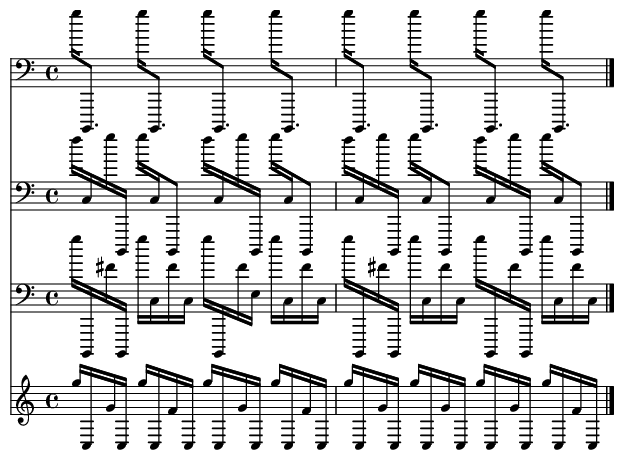

8/8 [==============================] - 68s 670ms/step - c_loss: -235.9623 - c_wass_loss: -968.5760 - c_gp: 73.2614 - g_loss: -433.6766
Epoch 2/1000
8/8 [==============================] - 3s 338ms/step - c_loss: -78.4814 - c_wass_loss: -121.7310 - c_gp: 4.3250 - g_loss: -325.3678
Epoch 3/1000
8/8 [==============================] - 3s 335ms/step - c_loss: -47.7349 - c_wass_loss: -74.2979 - c_gp: 2.6563 - g_loss: -934.7620
Epoch 4/1000
8/8 [==============================] - 3s 344ms/step - c_loss: -64.9462 - c_wass_loss: -97.0442 - c_gp: 3.2098 - g_loss: -1014.0729
Epoch 5/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -68.2844 - c_wass_loss: -95.7924 - c_gp: 2.7508 - g_loss: -732.2009
Epoch 6/1000
8/8 [==============================] - 3s 343ms/step - c_loss: -73.8245 - c_wass_loss: -112.7139 - c_gp: 3.8889 - g_loss: -623.9779
Epoch 7/1000
8/8 [==============================] - 3s 370ms/step - c_loss: -75.6474 - c_wass_loss: -124.5611 - c_gp: 4.8914 - g_loss: -634.81

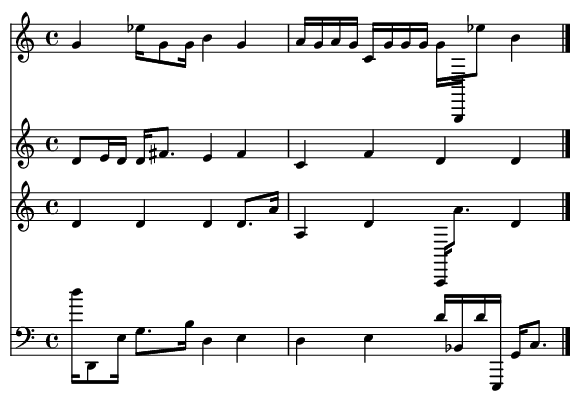

8/8 [==============================] - 4s 566ms/step - c_loss: -44.7196 - c_wass_loss: -59.3530 - c_gp: 1.4633 - g_loss: 128.5208
Epoch 102/1000
8/8 [==============================] - 3s 333ms/step - c_loss: -40.1916 - c_wass_loss: -71.3201 - c_gp: 3.1128 - g_loss: 132.6861
Epoch 103/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -44.2231 - c_wass_loss: -61.7405 - c_gp: 1.7517 - g_loss: 114.7743
Epoch 104/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -43.2559 - c_wass_loss: -62.6678 - c_gp: 1.9412 - g_loss: 127.4810
Epoch 105/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -41.4786 - c_wass_loss: -67.6707 - c_gp: 2.6192 - g_loss: 117.2059
Epoch 106/1000
8/8 [==============================] - 3s 376ms/step - c_loss: -43.5023 - c_wass_loss: -68.5716 - c_gp: 2.5069 - g_loss: 96.0475
Epoch 107/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -41.3996 - c_wass_loss: -65.0572 - c_gp: 2.3658 - g_loss: 138.6117
E

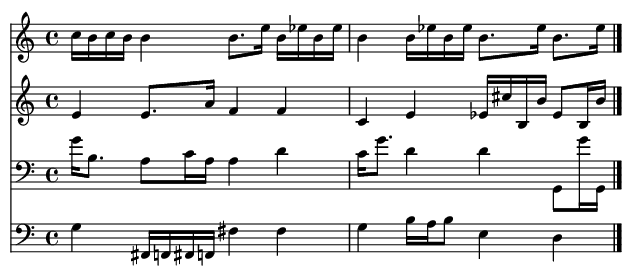

8/8 [==============================] - 4s 595ms/step - c_loss: -30.7079 - c_wass_loss: -50.4177 - c_gp: 1.9710 - g_loss: 82.5630
Epoch 202/1000
8/8 [==============================] - 3s 318ms/step - c_loss: -35.3636 - c_wass_loss: -49.5255 - c_gp: 1.4162 - g_loss: 84.5346
Epoch 203/1000
8/8 [==============================] - 2s 322ms/step - c_loss: -33.6827 - c_wass_loss: -54.3382 - c_gp: 2.0656 - g_loss: 122.0650
Epoch 204/1000
8/8 [==============================] - 2s 320ms/step - c_loss: -20.1792 - c_wass_loss: -56.5885 - c_gp: 3.6409 - g_loss: 141.7550
Epoch 205/1000
8/8 [==============================] - 3s 366ms/step - c_loss: -36.2670 - c_wass_loss: -45.7538 - c_gp: 0.9487 - g_loss: 101.2183
Epoch 206/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -34.4906 - c_wass_loss: -48.3686 - c_gp: 1.3878 - g_loss: 112.0003
Epoch 207/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -33.9856 - c_wass_loss: -50.0503 - c_gp: 1.6065 - g_loss: 106.6774
Ep

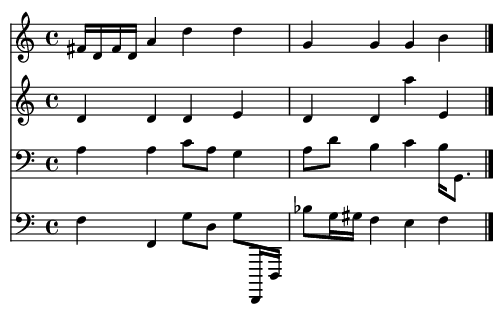

8/8 [==============================] - 4s 513ms/step - c_loss: -50.3910 - c_wass_loss: -77.4281 - c_gp: 2.7037 - g_loss: 35.1887
Epoch 302/1000
8/8 [==============================] - 3s 319ms/step - c_loss: -48.6311 - c_wass_loss: -75.6713 - c_gp: 2.7040 - g_loss: 24.6757
Epoch 303/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -48.1595 - c_wass_loss: -78.3399 - c_gp: 3.0180 - g_loss: 48.2960
Epoch 304/1000
8/8 [==============================] - 3s 382ms/step - c_loss: -51.2008 - c_wass_loss: -79.8232 - c_gp: 2.8622 - g_loss: 52.8601
Epoch 305/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -52.6083 - c_wass_loss: -86.4009 - c_gp: 3.3793 - g_loss: 26.2523
Epoch 306/1000
8/8 [==============================] - 2s 320ms/step - c_loss: -55.3060 - c_wass_loss: -74.7651 - c_gp: 1.9459 - g_loss: 33.1240
Epoch 307/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -45.6415 - c_wass_loss: -79.3975 - c_gp: 3.3756 - g_loss: 35.0131
Epoch 3

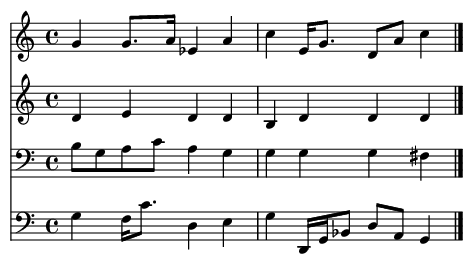

8/8 [==============================] - 3s 451ms/step - c_loss: -61.0284 - c_wass_loss: -95.9569 - c_gp: 3.4929 - g_loss: 19.2778
Epoch 402/1000
8/8 [==============================] - 3s 328ms/step - c_loss: -55.9581 - c_wass_loss: -93.9469 - c_gp: 3.7989 - g_loss: 7.6060
Epoch 403/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -59.2004 - c_wass_loss: -87.3476 - c_gp: 2.8147 - g_loss: 22.1460
Epoch 404/1000
8/8 [==============================] - 3s 364ms/step - c_loss: -66.9936 - c_wass_loss: -92.4720 - c_gp: 2.5478 - g_loss: 9.1558
Epoch 405/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -60.4266 - c_wass_loss: -92.7530 - c_gp: 3.2326 - g_loss: 22.5130
Epoch 406/1000
8/8 [==============================] - 3s 399ms/step - c_loss: -64.8244 - c_wass_loss: -92.2833 - c_gp: 2.7459 - g_loss: 17.6664
Epoch 407/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -58.3766 - c_wass_loss: -91.2728 - c_gp: 3.2896 - g_loss: 20.5883
Epoch 408

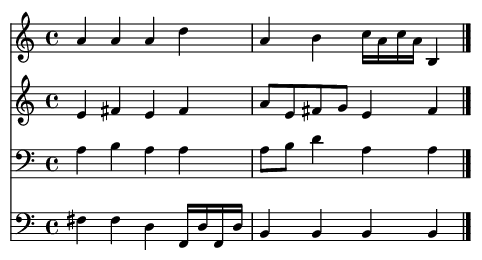

8/8 [==============================] - 3s 456ms/step - c_loss: -64.6947 - c_wass_loss: -96.0507 - c_gp: 3.1356 - g_loss: 13.4529
Epoch 502/1000
8/8 [==============================] - 3s 330ms/step - c_loss: -34.7320 - c_wass_loss: -119.3389 - c_gp: 8.4607 - g_loss: 11.6026
Epoch 503/1000
8/8 [==============================] - 3s 347ms/step - c_loss: -60.4556 - c_wass_loss: -108.3447 - c_gp: 4.7889 - g_loss: 8.2345
Epoch 504/1000
8/8 [==============================] - 3s 409ms/step - c_loss: -72.4236 - c_wass_loss: -99.5088 - c_gp: 2.7085 - g_loss: 34.8794
Epoch 505/1000
8/8 [==============================] - 3s 327ms/step - c_loss: -59.3230 - c_wass_loss: -98.6690 - c_gp: 3.9346 - g_loss: 25.7336
Epoch 506/1000
8/8 [==============================] - 3s 331ms/step - c_loss: -54.1601 - c_wass_loss: -102.1211 - c_gp: 4.7961 - g_loss: 7.9380
Epoch 507/1000
8/8 [==============================] - 3s 327ms/step - c_loss: -58.3677 - c_wass_loss: -107.6699 - c_gp: 4.9302 - g_loss: 22.4147
Epoch

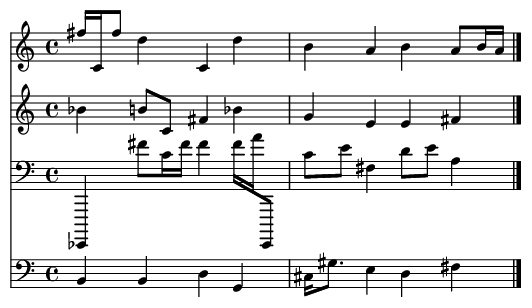

8/8 [==============================] - 3s 452ms/step - c_loss: -62.6628 - c_wass_loss: -114.7200 - c_gp: 5.2057 - g_loss: 32.4041
Epoch 602/1000
8/8 [==============================] - 2s 321ms/step - c_loss: -71.3351 - c_wass_loss: -112.0432 - c_gp: 4.0708 - g_loss: 7.5713
Epoch 603/1000
8/8 [==============================] - 3s 363ms/step - c_loss: -71.7993 - c_wass_loss: -108.5803 - c_gp: 3.6781 - g_loss: 19.1491
Epoch 604/1000
8/8 [==============================] - 3s 347ms/step - c_loss: -48.4663 - c_wass_loss: -121.9086 - c_gp: 7.3442 - g_loss: 26.7731
Epoch 605/1000
8/8 [==============================] - 3s 328ms/step - c_loss: -72.5002 - c_wass_loss: -108.7474 - c_gp: 3.6247 - g_loss: 35.6540
Epoch 606/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -58.4422 - c_wass_loss: -119.6720 - c_gp: 6.1230 - g_loss: 36.5160
Epoch 607/1000
8/8 [==============================] - 3s 370ms/step - c_loss: -68.3083 - c_wass_loss: -111.5212 - c_gp: 4.3213 - g_loss: 8.0711
Ep

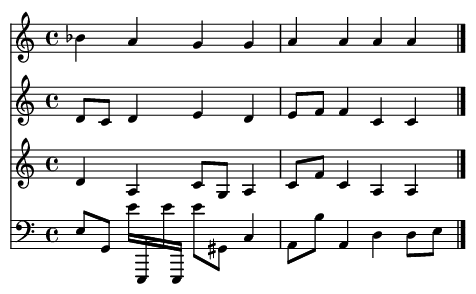

8/8 [==============================] - 4s 468ms/step - c_loss: -73.8577 - c_wass_loss: -120.0629 - c_gp: 4.6205 - g_loss: 20.3471
Epoch 702/1000
8/8 [==============================] - 3s 341ms/step - c_loss: -91.3498 - c_wass_loss: -127.8309 - c_gp: 3.6481 - g_loss: 17.9532
Epoch 703/1000
8/8 [==============================] - 3s 322ms/step - c_loss: -77.4802 - c_wass_loss: -118.6160 - c_gp: 4.1136 - g_loss: 25.0400
Epoch 704/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -73.4797 - c_wass_loss: -113.1414 - c_gp: 3.9662 - g_loss: 21.2692
Epoch 705/1000
8/8 [==============================] - 3s 323ms/step - c_loss: -87.8661 - c_wass_loss: -129.6756 - c_gp: 4.1809 - g_loss: 23.0400
Epoch 706/1000
8/8 [==============================] - 3s 363ms/step - c_loss: -72.9965 - c_wass_loss: -126.2337 - c_gp: 5.3237 - g_loss: 28.1427
Epoch 707/1000
8/8 [==============================] - 3s 388ms/step - c_loss: -83.4136 - c_wass_loss: -139.0098 - c_gp: 5.5596 - g_loss: 39.7040


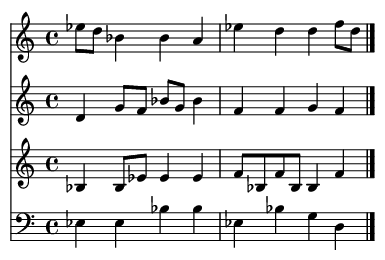

8/8 [==============================] - 4s 514ms/step - c_loss: -75.4002 - c_wass_loss: -125.4827 - c_gp: 5.0083 - g_loss: 23.3673
Epoch 802/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -90.6528 - c_wass_loss: -132.8773 - c_gp: 4.2225 - g_loss: 38.3324
Epoch 803/1000
8/8 [==============================] - 3s 328ms/step - c_loss: -90.8549 - c_wass_loss: -133.1690 - c_gp: 4.2314 - g_loss: 28.7660
Epoch 804/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -72.0346 - c_wass_loss: -120.9671 - c_gp: 4.8932 - g_loss: 20.9263
Epoch 805/1000
8/8 [==============================] - 3s 370ms/step - c_loss: -80.1994 - c_wass_loss: -118.5494 - c_gp: 3.8350 - g_loss: 24.2676
Epoch 806/1000
8/8 [==============================] - 3s 327ms/step - c_loss: -84.8241 - c_wass_loss: -126.6779 - c_gp: 4.1854 - g_loss: 36.8339
Epoch 807/1000
8/8 [==============================] - 3s 324ms/step - c_loss: -83.8300 - c_wass_loss: -124.5464 - c_gp: 4.0716 - g_loss: 10.6276


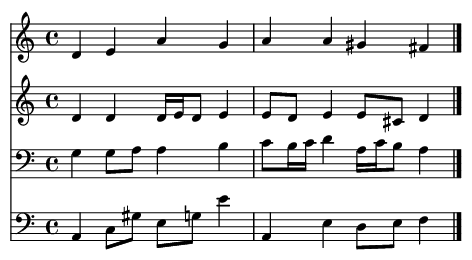

8/8 [==============================] - 3s 452ms/step - c_loss: -74.0113 - c_wass_loss: -134.6235 - c_gp: 6.0612 - g_loss: 35.1193
Epoch 902/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -79.9104 - c_wass_loss: -140.2979 - c_gp: 6.0387 - g_loss: 11.4628
Epoch 903/1000
8/8 [==============================] - 3s 325ms/step - c_loss: -90.0748 - c_wass_loss: -126.1845 - c_gp: 3.6110 - g_loss: 15.9837
Epoch 904/1000
8/8 [==============================] - 3s 368ms/step - c_loss: -90.7293 - c_wass_loss: -137.3139 - c_gp: 4.6585 - g_loss: 5.6749
Epoch 905/1000
8/8 [==============================] - 3s 331ms/step - c_loss: -102.8060 - c_wass_loss: -149.6100 - c_gp: 4.6804 - g_loss: 9.9645
Epoch 906/1000
8/8 [==============================] - 3s 326ms/step - c_loss: -89.7795 - c_wass_loss: -142.8193 - c_gp: 5.3040 - g_loss: 37.7872
Epoch 907/1000
8/8 [==============================] - 3s 389ms/step - c_loss: -35.8416 - c_wass_loss: -148.2306 - c_gp: 11.2389 - g_loss: 8.9435
E

In [19]:
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator_callback,
    ],
)

# 새로운 악보 생성

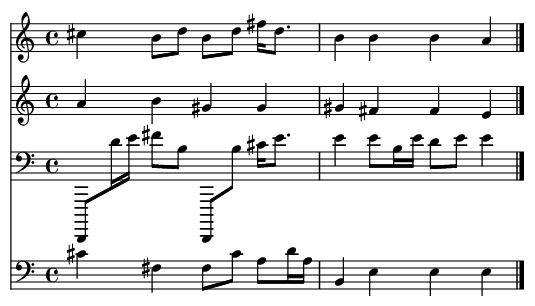

In [20]:
num_scores = 1
chords_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
style_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
melody_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
groove_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
random_latent_vectors = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music = generator(random_latent_vectors)
generated_music = generated_music.numpy()

notes_to_midi(
    generated_music, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename="output_midi"
)
display(Image(str(draw_score("output_midi", 0).write('lily.png'))))

## 화음 잡음 변경

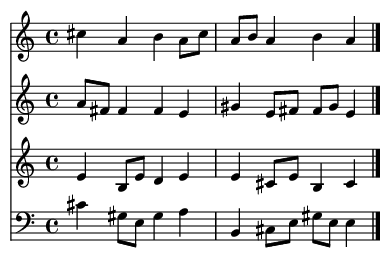

In [21]:
chords_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_2 = [
    chords_random_latent_vectors_2,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_2 = generator(random_latent_vectors_2)
generated_music_2 = generated_music_2.numpy()
notes_to_midi(
    generated_music_2,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_chords_changed",
)
display(Image(str(draw_score("output_midi_chords_changed", 0).write('lily.png'))))

## 스타일 잡음 변경

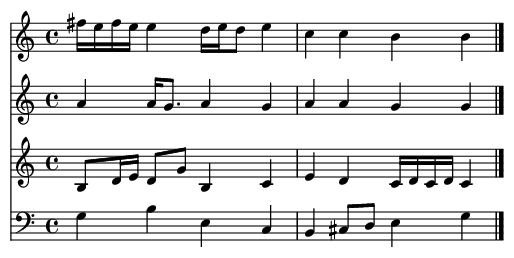

In [22]:
style_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_3 = [
    chords_random_latent_vectors,
    style_random_latent_vectors_2,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_3 = generator(random_latent_vectors_3)
generated_music_3 = generated_music_3.numpy()
notes_to_midi(
    generated_music_3,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_style_changed",
)
display(Image(str(draw_score("output_midi_style_changed", 0).write('lily.png'))))

## 멜로디 잡음 변경

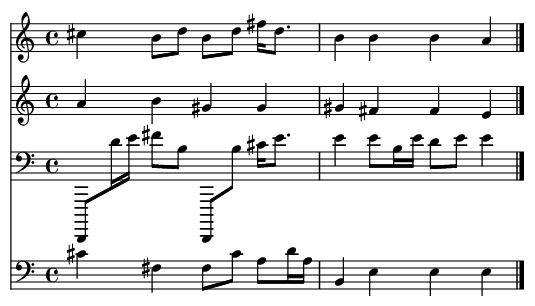

In [23]:
melody_random_latent_vectors_2 = np.copy(melody_random_latent_vectors)
melody_random_latent_vectors_2[:, 0, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_4 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors_2,
    groove_random_latent_vectors,
]
generated_music_4 = generator(random_latent_vectors_4)
generated_music_4 = generated_music_4.numpy()
notes_to_midi(
    generated_music_4,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_melody_changed",
)
display(Image(str(draw_score("output_midi_melody_changed", 0).write('lily.png'))))

## 리듬 잡음 변경

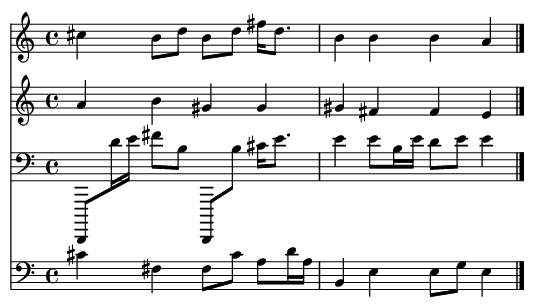

In [24]:
groove_random_latent_vectors_2 = np.copy(groove_random_latent_vectors)
groove_random_latent_vectors_2[:, -1, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_5 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors_2,
]
generated_music_5 = generator(random_latent_vectors_5)
generated_music_5 = generated_music_5.numpy()
notes_to_midi(
    generated_music_5,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_groove_changed",
)
display(Image(str(draw_score("output_midi_groove_changed", 0).write('lily.png'))))